In [1]:
%matplotlib inline
import sys

from u8timeseries import Prophet, KthValueAgoBaseline, ExponentialSmoothing, TimeSeries, Arima, AutoArima
from u8timeseries import StandardRegressiveModel
from u8timeseries.metrics import mape, overall_percentage_error, mase
from u8timeseries.backtesting import simulate_forecast_ar, simulate_forecast_regr

import pandas as pd
import numpy as np
from datetime import datetime
import time
import matplotlib.pyplot as plt

## Read data

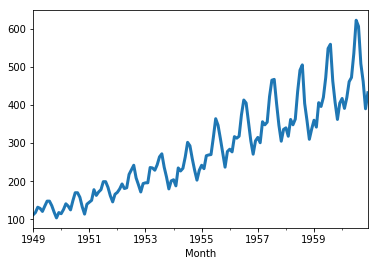

In [2]:
df = pd.read_csv('AirPassengers.csv')
series = TimeSeries.from_dataframe(df, 'Month', '#Passengers')
series.pd_series().plot(lw=3)

## Build three models

In [42]:
model_es = ExponentialSmoothing()
model_pr = Prophet()
# model_ar = Arima(2, 1, 5)
model_bl = KthValueAgoBaseline(K=12)

## Try one of the models

In [45]:
train, val = series.split_after(pd.Timestamp('19570101'))
model_es.fit(train)
pred = model_es.predict(len(val))

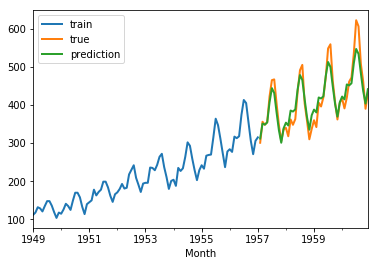

In [46]:
train.plot(lw=2, label='train')
val.plot(lw=2, label='true')
pred.plot(lw=2, label='prediction')
plt.legend()

## Simulate historical forecasting
This will simulate predictions that would have been done historically with a given model. It can take a while to produce, since the model is re-fit every time the simulated prediction time advances.

In [47]:
historical_fcast = simulate_forecast_ar(series, model_es, pd.Timestamp('19570101'), fcast_horizon_n=6, verbose=True)

100%|██████████| 42/42 [00:48<00:00,  1.26s/it]


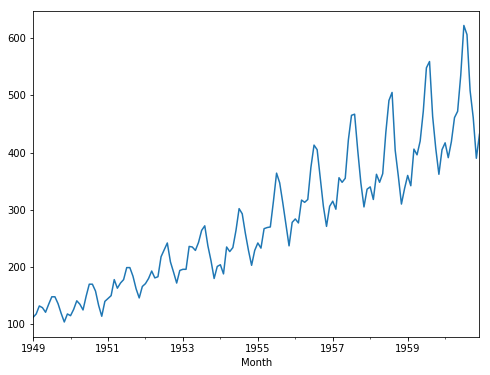

In [8]:
plt.figure(figsize=(8,6))
series.plot()
historical_fcast.plot(lw=3)

## Backtest the models on the data using a user-defined metric
Simulate 12-months ahead predictions done in the past, starting in January 1955.

In [46]:
def backtest_model(model):
    tic = time.time()
    train_val_series = get_train_val_series(series, start=pd.Timestamp('19550101'), nr_points_in_val=12)
    res = backtest_autoregressive_model(model, train_val_series, mape)
    tac = time.time()
    print('Backtest done in %.2f s.' % (tac-tic))
    return res

In [47]:
res_es = backtest_model(model_es)
res_pr = backtest_model(model_pr)
res_bl = backtest_model(model_bl)

Backtest done in 67.60 s.


/Users/julien/anaconda3/envs/timeseries/lib/python3.6/site-packages/fbprophet/forecaster.py:794: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  min_dt = dt.iloc[dt.nonzero()[0]].min()


Backtest done in 121.06 s.
Backtest done in 0.56 s.


### Plot the user-defined backtesting results

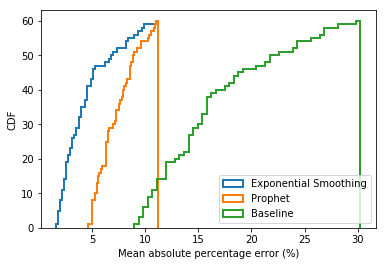

In [12]:
plt.hist(res_es, bins=50, cumulative=True, histtype='step', 
         lw=2, label='Exponential Smoothing');
plt.hist(res_pr, bins=50, cumulative=True, histtype='step', 
         lw=2, label='Prophet');
plt.hist(res_bl, bins=50, cumulative=True, histtype='step', 
         lw=2, label='Baseline');

plt.xlabel('Mean absolute percentage error (%)')
plt.ylabel('CDF')
plt.legend(loc=4)

## Let's make an actual forecast!
Since Exponential Smoothing is better in backtests, let's use this one.

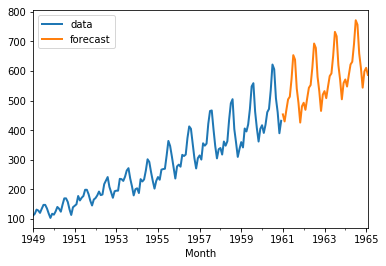

In [13]:
model_es.fit(series)
pred = model_es.predict(n = 50)

series.pd_series().plot(label='data', lw=2)
pred.pd_series().plot(label='forecast', lw=2)
plt.legend()

## Ensembling several predictions
### Let's simulate forecasts done by an ensemble of models

In [11]:
""" New way - backtest over time
"""
models = [ExponentialSmoothing(), Prophet()]

historical_ar_preds = [simulate_forecast_ar(series, m, pd.Timestamp('19570101'), fcast_horizon_n=6)
                       for m in models]

...........................................

/Users/julien/anaconda3/envs/timeseries/lib/python3.6/site-packages/fbprophet/forecaster.py:794: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  min_dt = dt.iloc[dt.nonzero()[0]].min()


.........................................

In [12]:
""" Combine the individual simulated predicitons
"""
regrModel = StandardRegressiveModel(train_n_points=12)

series_val = series.intersect(historical_ar_preds[0])

historical_pred = simulate_forecast_regr(historical_ar_preds, series_val, regrModel,
                                         pd.Timestamp('19580101'), fcast_horizon_n=6)

..............................

MASE Error Exponential smoothing: 0.30355683767540287
MASE Error Prophet: 0.725100470342364
MASE Error ensemble: 0.5273090423055782


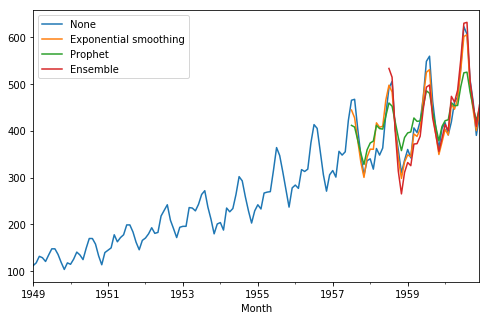

In [13]:
""" Compute errors and plot
"""
plt.figure(figsize=(8,5))

series.plot()
for i, m in enumerate(models):
    historical_ar_preds[i].plot(label=str(m))
    
    # intersect last part, to compare everything with ensemble
    ar_pred = historical_ar_preds[i].intersect(historical_pred)
       
    mase_er = mase(series.intersect(historical_pred), ar_pred)
    print('MASE Error {}: {}'.format(m, mase_er))

print('MASE Error ensemble: {}'.format(mase(series.intersect(historical_pred), historical_pred)))

historical_pred.plot(label='Ensemble')

plt.legend()

/Users/julien/anaconda3/envs/timeseries/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/julien/anaconda3/envs/timeseries/lib/python3.6/site-packages/fbprophet/forecaster.py:794: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  min_dt = dt.iloc[dt.nonzero()[0]].min()
/Users/julien/anaconda3/envs/timeseries/lib/python3.6/site-packages/statsmodels/tsa/arima_model.py:1833: RuntimeWarning: invalid value encountered in sqrt
  fcerr = np.sqrt(np.cumsum(cumsum_n(ma_rep, self.k_diff)**2)*sigma2)
/Users/julien/anaconda3/envs/timeseries/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/julien/anaconda3/envs/timeseries/lib/python3.6/site-packages/

Error:
Exponential smoothing: MASE = 0.5874211247355211
ARIMA(12,1,0): MASE = 0.4977247596659544
Prophet: MASE = 1.8978508373358491
Ensemble MASE = 0.44913929656774465

Coefficients:
Exponential smoothing: 1.4562907255960662
ARIMA(12,1,0): 0.011191208537334574
Prophet: -0.4649671473685668


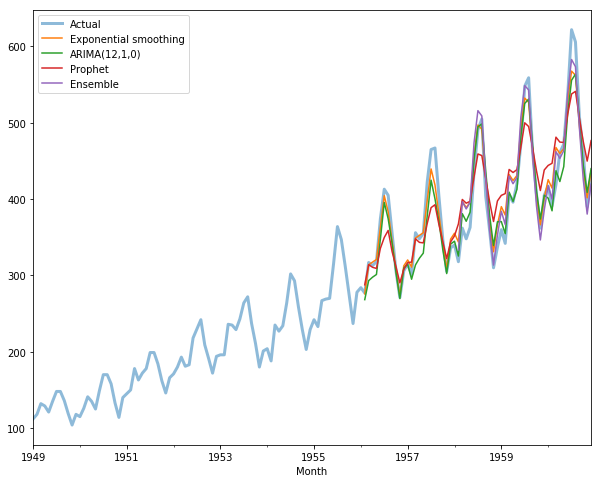

In [43]:
""" Old way - one shot prediction only
"""
models = [ExponentialSmoothing(), Arima(), Prophet()]

trainval, test = series.split_after(pd.Timestamp('19580101'))
train, val = trainval.split_after(pd.Timestamp('19560101'))

# Build a few predicitions on validation set
for m in models:
    m.fit(train)
preds_val = [m.predict(len(val)) for m in models]  # this is a List[TimeSeries]

# Train an ensemble model from those auto-regressive predictions (on validation set)
regrModel = StandardRegressiveModel()
regrModel.fit(preds_val, val)

# Re-fit models on everything before test set
for m in models:
    m.fit(trainval)

# Produce test set prediction from auto-regressive, and then ensemble model
preds_test = [m.predict(len(test)) for m in models]
ensemble_pred = regrModel.predict(preds_test)

# Plot
plt.figure(figsize=(10,8))
series.plot(lw=3, label='Actual', alpha=0.5)
for i in range(len(models)):
    preds_val[i].append(preds_test[i]).plot(plot_ci=False, label=str(models[i]))
ensemble_pred.plot(label='Ensemble')
plt.legend()

# Display errors:
print('Error:')
for i in range(len(models)):
    print('{}: MASE = {}'.format(str(models[i]), mase(preds_test[i], test)))
print('Ensemble MASE = {}\n'.format(mase(ensemble_pred, test)))

# Display coefficients:
print('Coefficients:')
for m, coef in zip(models, regrModel.model.coef_):
    print('{}: {}'.format(m, coef))

## Example of forecasting using a supervised model and extra features
Here we show how to forecast with a supervised model, with an additional dummy (constant) feature. Note that in this case the resulting forecasts are not so interesting, as random forest simply predicts the last value because our extra feature is not informative.

In [ ]:
""" TODO
"""

if False:
    df_with_feature = df.copy()
    df_with_feature['dummy_feature'] = [1 for _ in range(len(df))]

    model_rf.fit(df_with_feature, '#Passengers', 'Month', 'month', feature_columns=['dummy_feature'])

    # Predict for three years
    test_dates = [datetime(1961, m, 1) for m in range(1, 13)] + \
                 [datetime(1962, m, 1) for m in range(1, 13)] + \
                 [datetime(1963, m, 1) for m in range(1, 13)]

    test_df = pd.DataFrame({'Month': test_dates})
    test_df['dummy_feature'] = [1 for _ in range(len(test_df))]

    predicted_df = model_rf.predict(test_df)

    plt.figure()
    plt.plot(df['Month'], df['#Passengers'])
    plt.plot(predicted_df['Month'], predicted_df['yhat'])